In [1]:
# Project-specific Scripts
import Scripts.plotting_functions as pf
import Scripts.models as m

# Data Manipulation and Analysis
import pandas as pd

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Machine Learning
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, classification_report, accuracy_score
from sklearn.feature_selection import mutual_info_classif, chi2, f_classif, SelectKBest

# Optimization and Model Saving
import optuna

# <font color='White'><p style="font-size: 40px;"><b>Spaceship Titanic EDA</b></p>

### "Introduction"

Welcome to our mission in the year 2912, where we tackle the cosmic mystery of the Spaceship Titanic. Our goal is to predict which passengers were transported to an alternate dimension after the spaceship collided with a spacetime anomaly. By analyzing the recovered records, we aim to build a robust model to assist rescue crews in retrieving the lost passengers. Join us as we delve into this interstellar dataset and strive to change history.

- Dataset Focus: Spaceship Titanic passenger transport prediction.
- Objective: Understand data structure, conduct exploratory data analysis (EDA), and develop predictive models with hyperparameter tuning and evaluation.

Key Steps:
- Analyze Data Structure:
    - Understand the features in the dataset, including categorical and numerical variables.
    - Identify target variable and potential predictors.

- Extract Insights during EDA:
    - Perform EDA to uncover patterns and relationships in the data.
    - Visualize distributions and correlations.

- Feature Engineering:
    - Apply transformations and encoding to categorical variables.

- Fit Predictive Models:
    - Develop machine learning models, focusing on RandomForestClassifier and XGBoost.
    - Use tools like Optuna for hyperparameter tuning.

- Evaluate Model Performance:
    - Assess model accuracy, precision, recall, and ROC AUC score.
    - Compare performance across different model configurations.

- Refine and Optimize Models:
    - Iterate on model improvements based on evaluation metrics.
    - Ensure the final model is robust and generalizable.

Goal: 
- Develop an optimized model to predict which passengers were transported to an alternate dimension, aiding rescue efforts and altering the course of this cosmic event.

## Database Structure

In [2]:
train_df = pd.read_csv("Data/train.csv")

In [3]:
print(train_df.shape)
train_df.sample(5)

(8693, 14)


,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
4658,4965_01,Earth,NaN,E/308/P,TRAPPIST-1e,21.0,False,457.0,79.0,1134.0,0.0,0.0,Calvia Corman,False
463,0503_01,Mars,False,F/90/S,TRAPPIST-1e,10.0,False,0.0,0.0,0.0,0.0,0.0,Gal Fone,True
7407,7914_03,Earth,False,G/1278/P,TRAPPIST-1e,47.0,False,397.0,0.0,321.0,0.0,5.0,Eriky Munozaley,True
1610,1709_03,Mars,False,NaN,TRAPPIST-1e,35.0,False,1313.0,0.0,24.0,0.0,1.0,Bleark Minen,False
8252,8816_03,Europa,True,B/340/S,55 Cancri e,15.0,False,0.0,0.0,0.0,0.0,0.0,Merops Diouselt,True


We identify that there is column "PassengerId" and "Name".

Before dropping them, let's check if the IDs are different in case there are duplicated names.

In [4]:
all_duplicated_names_sorted = train_df.loc[
    train_df["Name"].duplicated(keep=False)
    & train_df["PassengerId"].duplicated(keep=False)
].sort_values(by="Name")

all_duplicated_names_sorted.count()

PassengerId     0
HomePlanet      0
CryoSleep       0
Cabin           0
Destination     0
Age             0
VIP             0
RoomService     0
FoodCourt       0
ShoppingMall    0
Spa             0
VRDeck          0
Name            0
Transported     0
dtype: int64

There are no identical **"Names"** with the same **"PassangerID"**. That means some passengers do have the same name with different feature values.  

So We can move and delete it, because it will not be needed.

In [5]:
train_df = train_df.drop(columns=["PassengerId", "Name"])

Now, let's just take a look at duplicated values.

In [6]:
train_df.duplicated().sum()

15

We need to drop these duplicated values as well.

In [7]:
train_df = train_df.drop_duplicates()

Also, let's take a look at null values.

In [8]:
train_df.isnull().sum()

HomePlanet      201
CryoSleep       217
Cabin           193
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Transported       0
dtype: int64

## Exploratory Data Analysis (EDA)

Let's dive into the dataset and see what can We learn from it.

### How many passangers were **"Transported"** to another dimension?

Transported
True     4363
False    4315
Name: count, dtype: int64


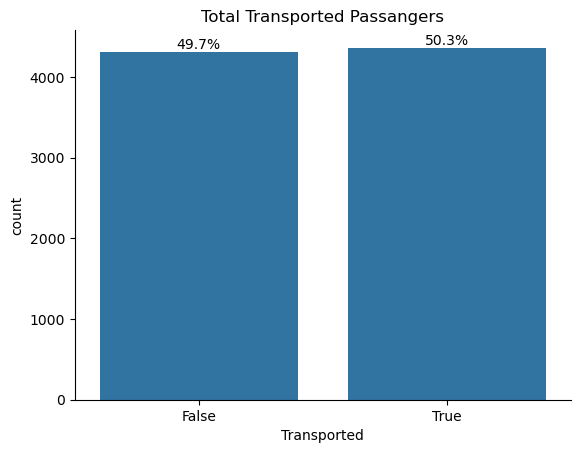

In [9]:
transported = train_df["Transported"].value_counts()

ax = pf.create_barplot(
    data=transported,
    title="Total Transported Passangers",
    xlabel="Transported",
    ylabel="count",
)

pf.add_percentage_to_plot(ax)
print(transported)

Well, the data looks almost perfectly balanced. **"50.3%"** of the data shows cases of **"Transported"** and **"49.3%"** of **"Not Transported"**.

By looking at this scenario, we don't have to worry that the model will not learn patterns that lead to each value of the target feature. Which if it's no balanced could cause some problems such as "Bias", "Poor Generalization" and "Misleading Accuracy".

With that in mind, we can continue with our EDA and learn more about the data itself.

### Feature Types

In [10]:
train_df.sample(5)

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported
2782,Europa,False,C/101/P,55 Cancri e,33.0,False,0.0,1001.0,2280.0,NaN,29.0,True
7647,Earth,False,F/1687/P,NaN,26.0,False,0.0,0.0,0.0,622.0,8.0,False
8265,Europa,False,C/290/P,55 Cancri e,25.0,False,1369.0,310.0,3.0,4502.0,377.0,False
931,Earth,False,F/184/S,55 Cancri e,24.0,False,252.0,0.0,0.0,449.0,0.0,False
3063,Mars,True,D/106/P,TRAPPIST-1e,35.0,False,0.0,0.0,0.0,0.0,0.0,False


- Categorical
    - Nominal:
        - HomePlanet
        - CryoSleep
        - Cabin
        - Destination
        - VIP

- Numerical
    - Continuous:
        - Age
    - Discrete:
        - RoomService
        - FoodCourt
        - ShoppingMall
        - Spa
        - VRDeck

Now with the features classified, what insights can We get from them based on the **"Transported"** feature.

#### Categorical Features

##### HomePlanet

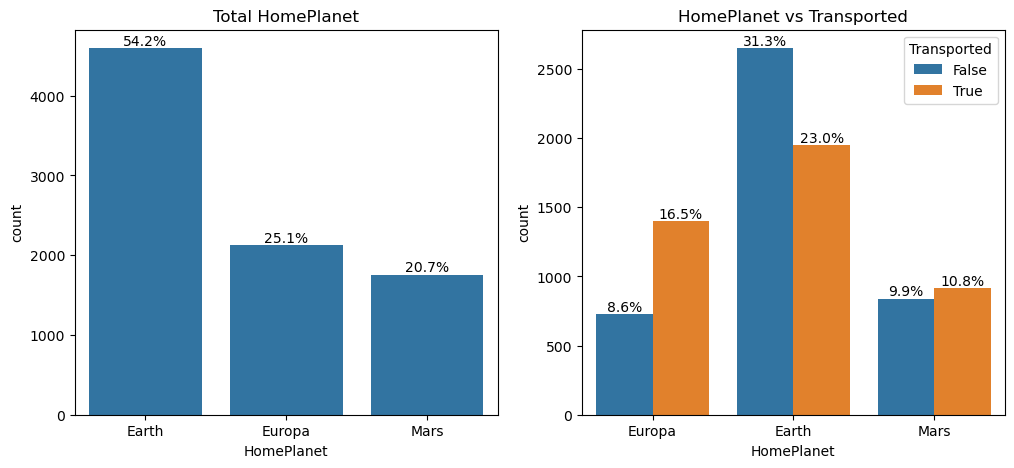

In [11]:
pf.create_bar_count_plot(
    data=train_df,
    x="HomePlanet",
    hue="Transported",
    title1="Total HomePlanet",
    title2="HomePlanet vs Transported",
    ylabel="count",
    rotate=False,
)

Out of the total **6755** passengers, the majority (54.2%) are located on **Earth** as their **HomePlanet**. **Europa** and **Mars** with 25.1% and 20.7%

The data shows notable differences in transport prevalence between **HomePlanets**:
- Earth: 23% of passengers were transported, whereas 31.3% were not.
- Europa: In contrast, 16.5% of passengers were transported, with 8.6% were not. Being the opposite of Earth.
- Mars: Like Europa, 10.8% of passengers were transported, with 9.9% were not.

That makes us thing that by living in other planet besides **Earth** tends to have a higher chance of being **Transported**.

In [12]:
transported_rate_earth = 23 / 31.3
transported_rate_europa = 16.5 / 8.6
transported_rate_mars = 10.8 / 9.9

ratio_transported_1 = transported_rate_europa / transported_rate_earth
ratio_transported_2 = transported_rate_mars / transported_rate_earth

print(f"The ratio of transported (Europa / Earth) is: {ratio_transported_1:.2f}")
print(f"The ratio of transported (Mars / Earth) is: {ratio_transported_2:.2f}")

The ratio of transported (Europa / Earth) is: 2.61
The ratio of transported (Mars / Earth) is: 1.48


The data highlights a small disparity in **Transported** between **HomePlanets**:

- Europa passengers has a transported ratio 2.61 times higher than Earth.
- Mars also has a higher ratio, 1.48 times higher than Earth.

**"HomePlanets"** shows a small difference between being transported or not. Let's keep that in mind.

##### CryoSleep

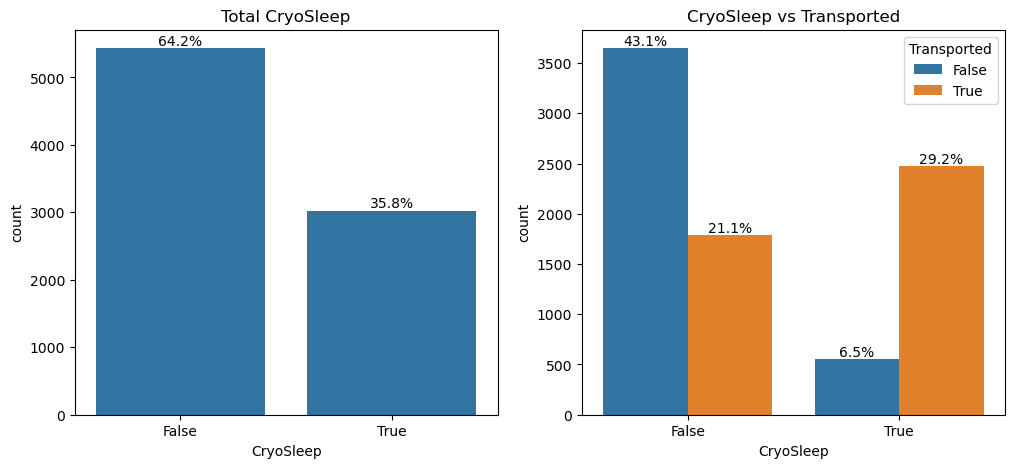

In [13]:
pf.create_bar_count_plot(
    data=train_df,
    x="CryoSleep",
    hue="Transported",
    title1="Total CryoSleep",
    title2="CryoSleep vs Transported",
    ylabel="count",
    rotate=False,
)

35.8% of the passengers used the **CryoSleep** service as a way of travelling. In the other hand, 64.2% choose to not use service.

- **CryoSleep**: 29.2% of passengers were transported, whereas 6.5% were not.
- **No CryoSleep**: The opposite happened here. 21.1% of passengers were transported and 43.1% were not.

There is a signifficant difference between using **CryoSleep** and not in terms of being **Transported**.

In [14]:
transported_rate_cryo = 29.2 / 6.5
transported_rate_no_cryo = 21.1 / 43.1

ratio_transported_cryo = transported_rate_cryo / transported_rate_no_cryo

print(
    f"The ratio of stroke rates (cryo sleep / no cryo sleep) is: {ratio_transported_cryo:.2f}"
)

The ratio of stroke rates (cryo sleep / no cryo sleep) is: 9.18


The data highlights a striking disparity in **Transported** between Cryo Sleep and No Cryo SLeep service users:
- Cryo Sleep passengers has a transported ratio 9.18 times higher.

That is surprising, **"CryoSleep"** might be an important feature for our model later.

##### Cabin

The values of this feature is composed by 3 parts.

Example: "G/1092/P"
- G -> Deck
- 1092 -> Number
- P -> Side

We need to keep that in mind, because We need to split later to get more insights.

But for now, it's important for us to check the different totals of how many people are in each **"Cabin"** and from them check how many were **"Transported"** or not.

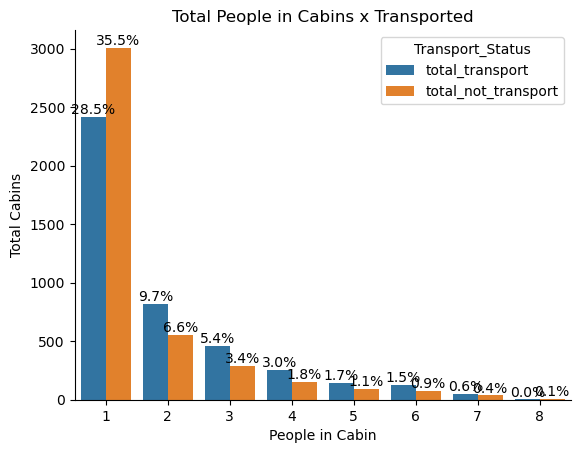

In [15]:
grouped_and_melted_df = (
    train_df.groupby("Cabin")
    .agg(
        total_people=("Cabin", "size"),
        transported=("Transported", "sum"),
        not_transported=("Transported", lambda x: (~x).sum()),
    )
    .reset_index()
    .groupby("total_people")
    .agg(
        cabins_count=("Cabin", "count"),
        total_transport=("transported", "sum"),
        total_not_transport=("not_transported", "sum"),
    )
    .reset_index()
    .melt(
        id_vars=["total_people"],
        value_vars=["total_transport", "total_not_transport"],
        var_name="Transport_Status",
        value_name="Count",
    )
)

ax = pf.create_barplot_hue(
    data=grouped_and_melted_df,
    x="total_people",
    y="Count",
    hue="Transport_Status",
    title="Total People in Cabins x Transported",
    xlabel="People in Cabin",
    ylabel="Total Cabins",
)
pf.add_percentage_to_plot(ax)

Let's break it down the information first:
- There are 1-7 people in a single Cabin.
- Each divided into **"Transported"** or not.
- "y-axis" being **"Total Cabins"**.

The less people are in a cabin, the higher the **"Total Cabins"** are occupied as well as **"Transported"**.

This leads us to think that cabins with less people have a higher chance of being **"Transported"** than the others.

Now, this is where We are going to be splitting the value to 3 other columns and get more insights. Also, dropping the **"Cabin"** column that will not be used.

In [16]:
cabin_df = train_df.copy()
cabin_df[["Deck", "Cabin_num", "Side"]] = cabin_df["Cabin"].str.split("/", expand=True)

**Deck**

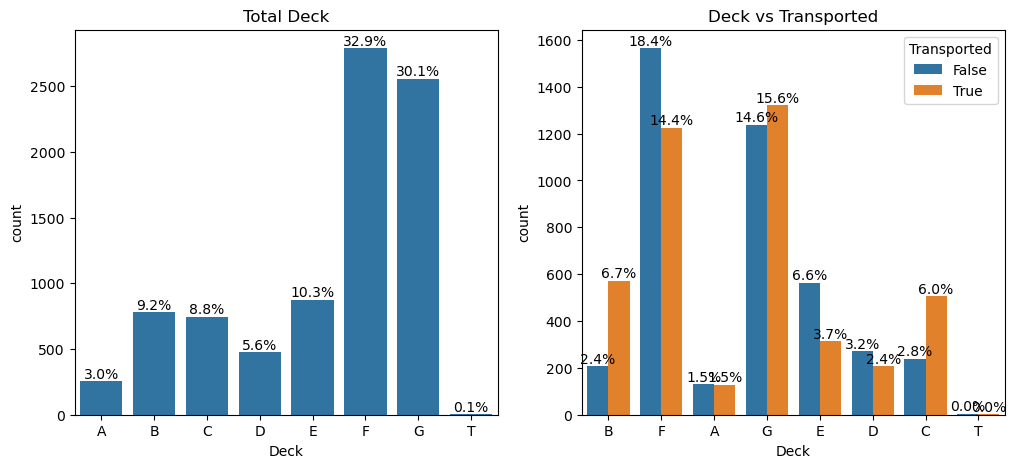

In [17]:
pf.create_bar_count_plot(
    data=cabin_df,
    x="Deck",
    hue="Transported",
    title1="Total Deck",
    title2="Deck vs Transported",
    ylabel="count",
    rotate=False,
)

This plot shows in which **"Deck"** the passengers were located. Where "F" and "G" are occupied for the majority of the clients.

However, there some interesting facts to point it out.

- "A", "B", "C" and "D": These are the fewest passengers among the other **"Decks"**. From those four decks, only two of them (B, C) has a higher percentage of people that were **"Transported"** instead of not **"Transported"**, with 6.7% and 2.4% consecutively. However, the other two decks (A, D), the percentages are pretty close to be even which it might indicate a preference on those 4 locations.
- "F" and "G": Here are located the majority of the population, but only "G" has a higher percentage of **"Transported"** with 15.6%
- "T": This deck apperantly was empty with no passengers there.
- "E": Nothing special about this **"Deck"**.

We can understand that some **"Decks"**  are probably cheaper than others causing to have more passengers. However, the fact that are more expensive places indicate a higher rate on being **"Transported"**, as presented on "B" and "C".

**Side**

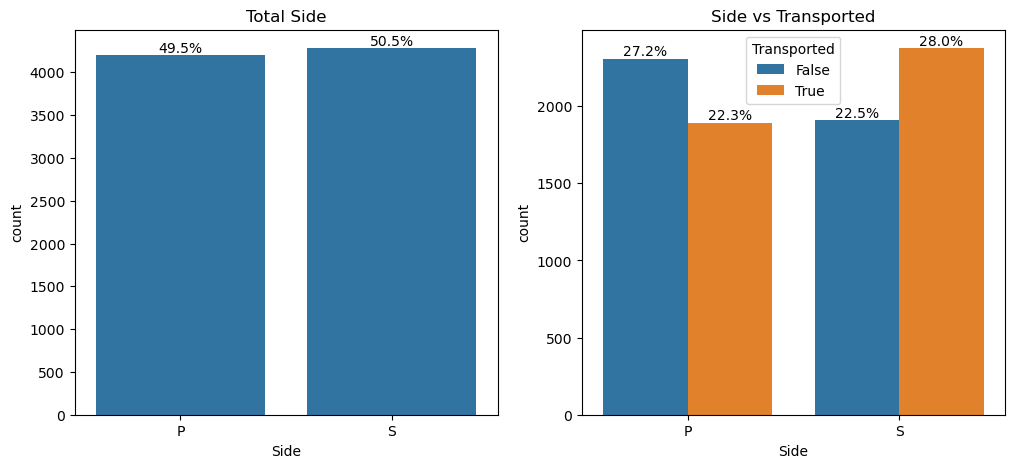

In [18]:
pf.create_bar_count_plot(
    data=cabin_df,
    x="Side",
    hue="Transported",
    title1="Total Side",
    title2="Side vs Transported",
    ylabel="count",
    rotate=False,
)

**"Side"** can be either P for **"Port"** or S for **"Starboard"**

This feature seems to be really balanced. There is not a big difference between the totals.

The bigger difference stands only on the **"Transported"** factor, where **"P"** has 22.3% and **"S"** has 28%

##### Destination

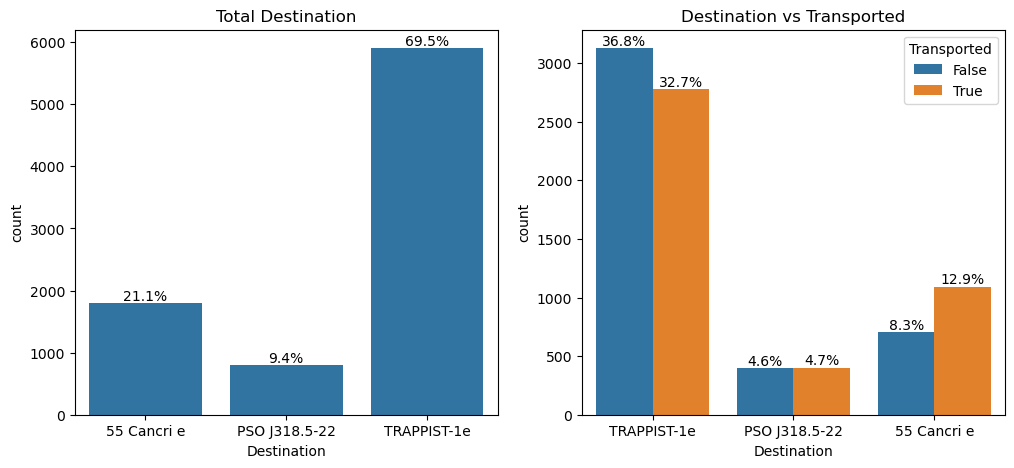

In [19]:
pf.create_bar_count_plot(
    data=train_df,
    x="Destination",
    hue="Transported",
    title1="Total Destination",
    title2="Destination vs Transported",
    ylabel="count",
    rotate=False,
)

In terms of quantity, **"TRAPPIST-1e"** has the highest amount with 69.5% as well as the highest percentage of **"Transported"** with 36.8%

However, We need to take a look on the ratio too.

In [20]:
destination_rate_55 = 12.9 / 8.3
destination_rate_pso = 4.7 / 4.6
destination_rate_trap = 32.7 / 36.8

destination_ratio = destination_rate_55 / destination_rate_pso
destination_ratio2 = destination_rate_55 / destination_rate_trap

print(
    f"The ratio of destination (55 Cancri e / PSO j318.5-22) is: {destination_ratio:.2f}"
)
print(
    f"The ratio of transported (55 Cancri e / TRAPPIST-1e) is: {destination_ratio2:.2f}"
)

The ratio of destination (55 Cancri e / PSO j318.5-22) is: 1.52
The ratio of transported (55 Cancri e / TRAPPIST-1e) is: 1.75


The data highlights a small disparity in **Transported** between **Destination**:

- "55 Cancri e" destination has a transported ratio 1.52 times higher than "PSO j318.5-22".
- "55 Cancri e" is 1.75 times higher than "TRAPPIST-1e".

**"Destination"** shows a small difference between being transported or not. Let's keep that in mind.

##### VIP

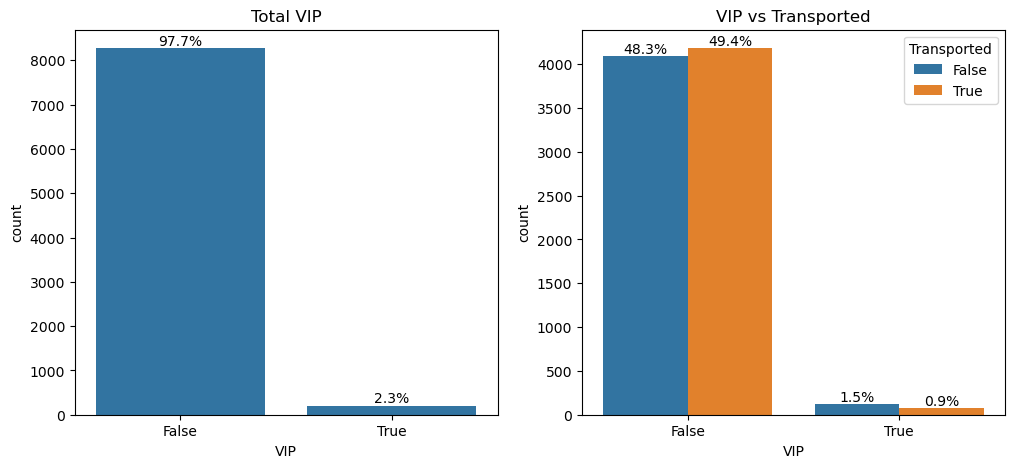

In [21]:
pf.create_bar_count_plot(
    data=train_df,
    x="VIP",
    hue="Transported",
    title1="Total VIP",
    title2="VIP vs Transported",
    ylabel="count",
    rotate=False,
)

**"VIP"** feature does not look to be super important.

- First, the data looks to be really imbalanced on the feature. 
- Second, there is not a big difference in terms of being **"Transported"** in buying or not the VIP service.

So, We are going to classify this as not an important feature for now.

#### Numericla Features

##### Age

To have a better look at the data, nothing better than classifying the **"Age"** into bins and seeing how the data behaves.

- Infants: 0-1 years old
- Toddlers: 1-3 years old
- Preschoolers: 3-5 years old
- Early School Age: 5-7 years old
- Middle Childhood: 7-12 years old
- Adolescents: 12-18 years old
- Young Adults: 18-30 years old
- Adults: 30-45 years old
- Middle-Aged Adults: 45-60 years old
- Seniors: 60+ years old

In [22]:
age_df = train_df.copy()

age_bins = [0, 1, 3, 5, 7, 12, 18, 30, 45, 60, float("inf")]
age_labels = [
    "Infants",
    "Toddlers",
    "Preschoolers",
    "Early School Age",
    "Middle Childhood",
    "Adolescents",
    "Young Adults",
    "Adults",
    "Mid Adults",
    "Seniors",
]

age_df["Age_group"] = pd.cut(
    age_df["Age"], bins=age_bins, labels=age_labels, right=False
)

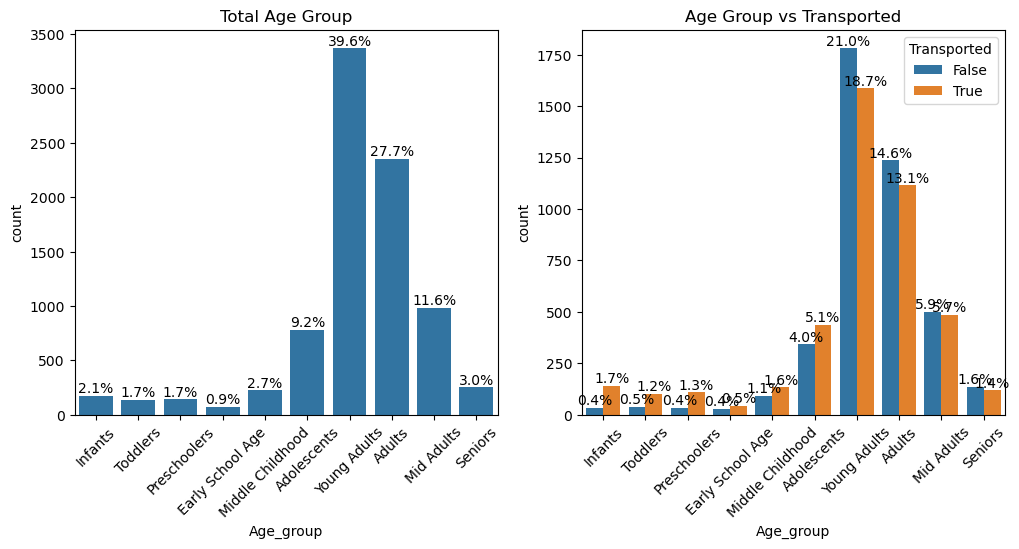

In [23]:
pf.create_bar_count_plot(
    data=age_df,
    x="Age_group",
    hue="Transported",
    title1="Total Age Group",
    title2="Age Group vs Transported",
    ylabel="count",
    rotate=True,
)

Analysis of **"Transported"** prevalence reveals distinct rates among these age groups:
- Young Adults -> The majority with 39.6% of the passengers.
- Preschoolers -> The lowest with 0.9% of the passengers.

There is a tendency that stands out immediatly when We check the second plot. From **"Infants"** to **"Middle Childhood"** the percentage of **"Transported"** is higher than not. However, if We see from **"Adolescents"** to **"Seniors"** this pattern changes. Even tough, the older groups have a higher percentage of **"Transported"**.

Probably there is a priority for people with kids to be transported first than the older people.

Let's take into consideration that Age_group has a good potential for being an important feature for our models.

##### RoomService

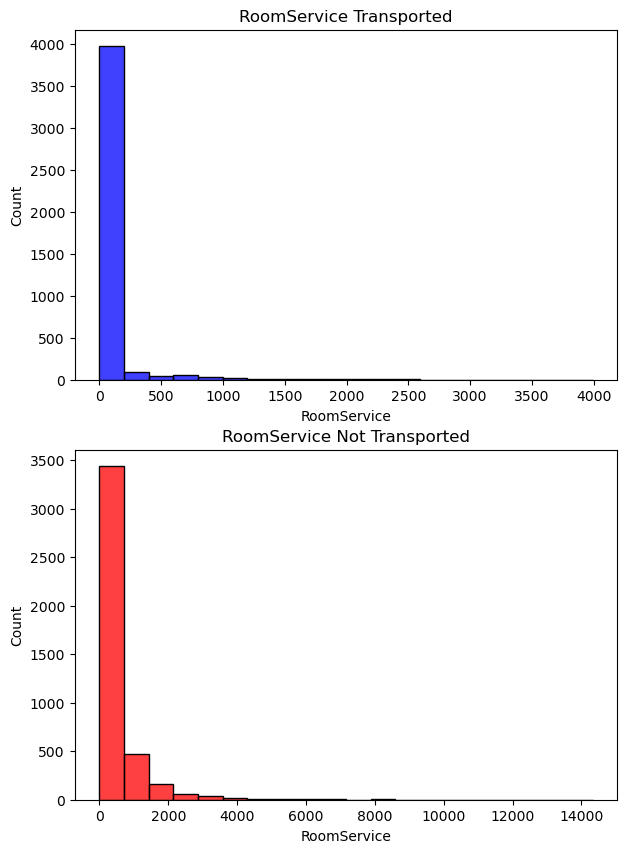

In [24]:
t = train_df["RoomService"].loc[train_df["Transported"] == True]
t2 = train_df["RoomService"].loc[train_df["Transported"] == False]

fig, ax = plt.subplots(2, 1, figsize=(7, 10))
sns.histplot(t, color="b", bins=20, ax=ax[0])
sns.histplot(t2, color="r", bins=20, ax=ax[1])
ax[0].set_title("RoomService Transported")
ax[1].set_title("RoomService Not Transported")
plt.show()

##### FoodCourt

Text(0.5, 1.0, 'FoodCourt Not Transported')

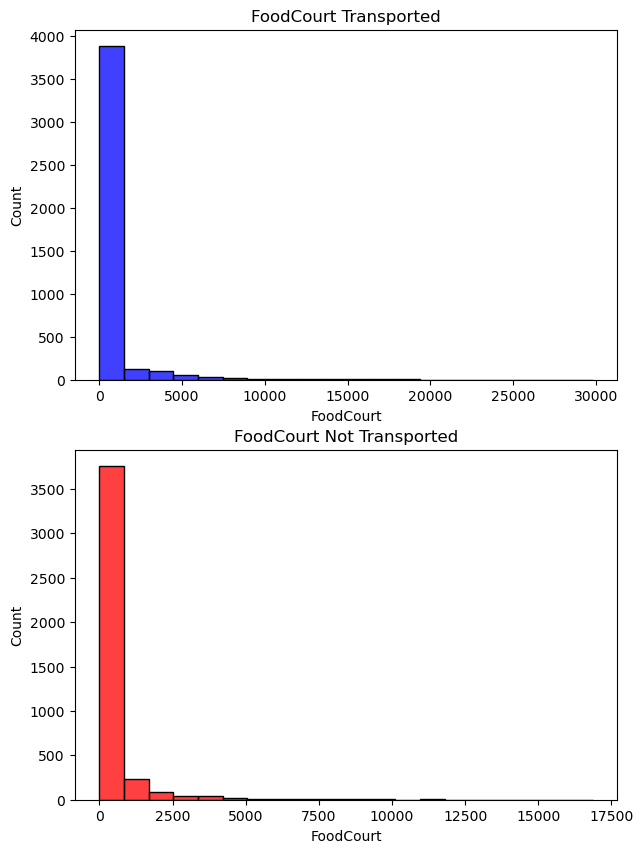

In [25]:
t = train_df["FoodCourt"].loc[train_df["Transported"] == True]
t2 = train_df["FoodCourt"].loc[train_df["Transported"] == False]

fig, ax = plt.subplots(2, 1, figsize=(7, 10))
sns.histplot(t, color="b", bins=20, ax=ax[0])
sns.histplot(t2, color="r", bins=20, ax=ax[1])
ax[0].set_title("FoodCourt Transported")
ax[1].set_title("FoodCourt Not Transported")

##### ShoppingMall

Text(0.5, 1.0, 'ShoppingMall Not Transported')

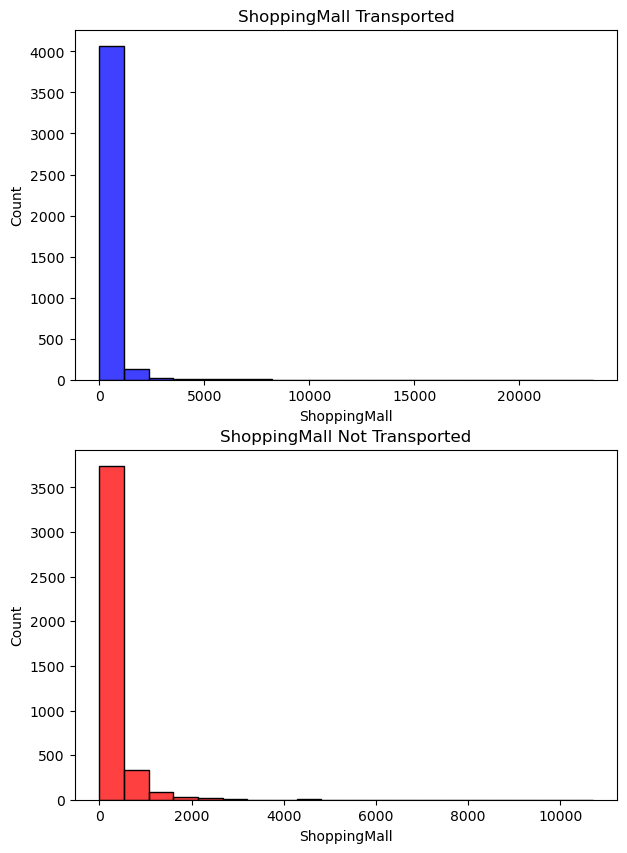

In [26]:
t = train_df["ShoppingMall"].loc[train_df["Transported"] == True]
t2 = train_df["ShoppingMall"].loc[train_df["Transported"] == False]

fig, ax = plt.subplots(2, 1, figsize=(7, 10))
sns.histplot(t, color="b", bins=20, ax=ax[0])
sns.histplot(t2, color="r", bins=20, ax=ax[1])
ax[0].set_title("ShoppingMall Transported")
ax[1].set_title("ShoppingMall Not Transported")

##### Spa

Text(0.5, 1.0, 'Spa Not Transported')

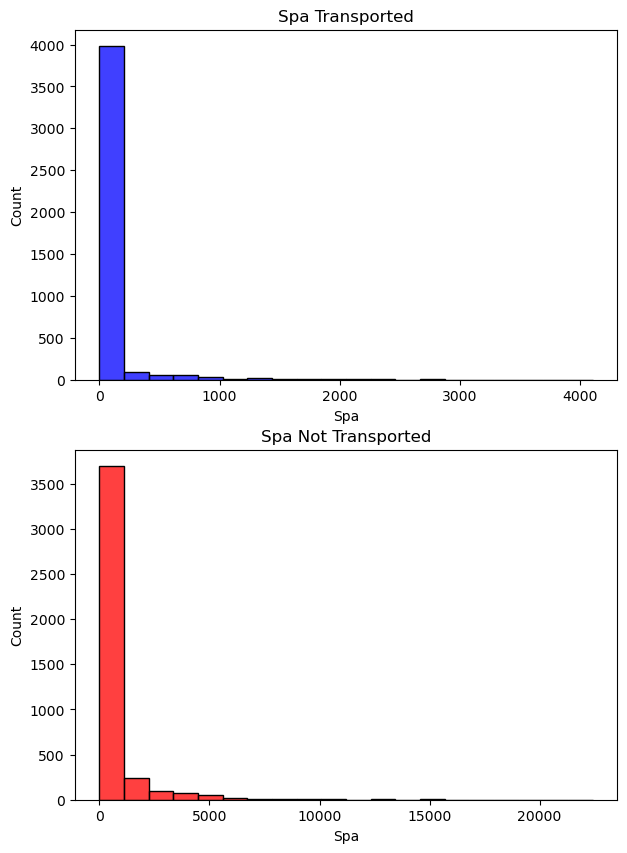

In [27]:
t = train_df["Spa"].loc[train_df["Transported"] == True]
t2 = train_df["Spa"].loc[train_df["Transported"] == False]

fig, ax = plt.subplots(2, 1, figsize=(7, 10))
sns.histplot(t, color="b", bins=20, ax=ax[0])
sns.histplot(t2, color="r", bins=20, ax=ax[1])
ax[0].set_title("Spa Transported")
ax[1].set_title("Spa Not Transported")

##### VRDeck

Text(0.5, 1.0, 'VRDeck Not Transported')

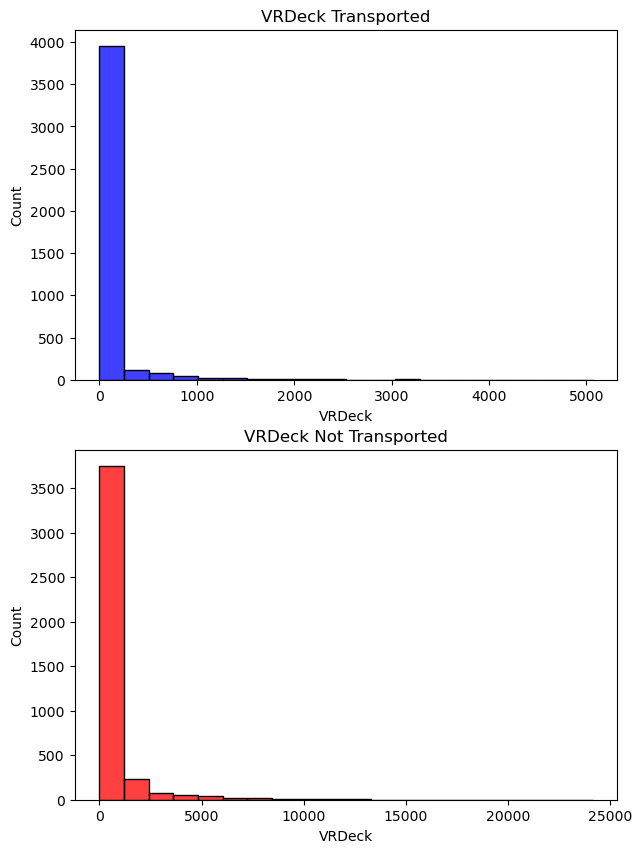

In [28]:
t = train_df["VRDeck"].loc[train_df["Transported"] == True]
t2 = train_df["VRDeck"].loc[train_df["Transported"] == False]

fig, ax = plt.subplots(2, 1, figsize=(7, 10))
sns.histplot(t, color="b", bins=20, ax=ax[0])
sns.histplot(t2, color="r", bins=20, ax=ax[1])
ax[0].set_title("VRDeck Transported")
ax[1].set_title("VRDeck Not Transported")

##### Total Expenses

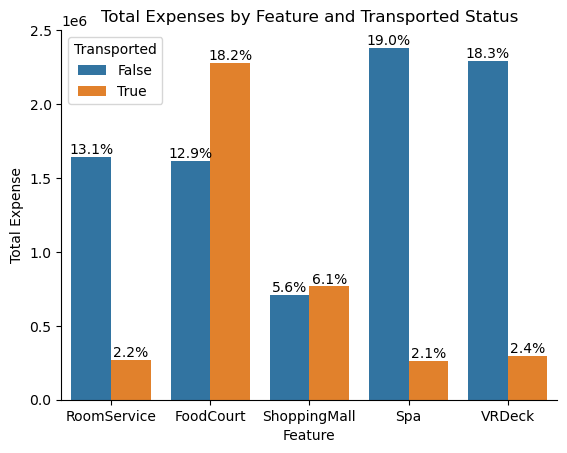

In [29]:
total_expenses = train_df.groupby("Transported")[
    ["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]
].sum()
total_expenses_long = total_expenses.reset_index().melt(
    id_vars="Transported", var_name="Feature", value_name="TotalExpense"
)

ax = pf.create_barplot_hue(
    data=total_expenses_long,
    x="Feature",
    y="TotalExpense",
    hue="Transported",
    title="Total Expenses by Feature and Transported Status",
    xlabel="Feature",
    ylabel="Total Expense",
)
pf.add_percentage_to_plot(ax)

## Train Test Split & Preprocessing Pipeline

First, Let's divide the target variable from the other features.

In [30]:
f1 = train_df.drop(columns=["Transported"])
t1 = train_df["Transported"].astype(int)

Here, We are going to declare the functions that will be used inside the **Pipeline**

In [31]:
numerical_features = [
    "Age",
    "RoomService",
    "FoodCourt",
    "ShoppingMall",
    "Spa",
    "VRDeck",
]
categorical_features = ["HomePlanet", "CryoSleep", "Cabin", "Destination", "VIP"]
features_to_encode = ["HomePlanet", "Destination", "Deck", "Side", "Age_group"]


def add_age_group(df):
    age_bins = [0, 1, 3, 5, 7, 12, 18, 30, 45, 60, float("inf")]
    age_labels = [
        "Infants",
        "Toddlers",
        "Preschoolers",
        "Early School Age",
        "Middle Childhood",
        "Adolescents",
        "Young Adults",
        "Adults",
        "Mid Adults",
        "Seniors",
    ]
    df["Age_group"] = pd.cut(df["Age"], bins=age_bins, labels=age_labels, right=False)
    return df


def to_int_transformer(df: pd.DataFrame):
    bool_features = ["CryoSleep", "VIP", "Cabin_num"]  # , 'Transported']
    df[bool_features] = df[bool_features].astype(int)
    return df


def split_cabin(df: pd.DataFrame):
    df[["Deck", "Cabin_num", "Side"]] = df["Cabin"].str.split("/", expand=True)
    df = df.drop(columns="Cabin")
    return df


def label_encode_features(df: pd.DataFrame):
    le = LabelEncoder()
    for feature in features_to_encode:
        df[feature] = le.fit_transform(df[feature])
    return df


def impute_numerical(df):
    imputer = SimpleImputer(strategy="constant", fill_value=0)
    numerical_data = df[numerical_features]
    imputed_data = imputer.fit_transform(numerical_data)
    return pd.DataFrame(imputed_data, columns=numerical_features, index=df.index)


def impute_categorical(df):
    imputer = SimpleImputer(strategy="most_frequent")
    categorical_data = df[categorical_features]
    imputed_data = imputer.fit_transform(categorical_data)
    return pd.DataFrame(imputed_data, columns=categorical_features, index=df.index)


def impute(df):
    num_imputed = impute_numerical(df)
    cat_imputed = impute_categorical(df)
    return pd.concat(
        [
            num_imputed,
            cat_imputed,
            df.drop(columns=numerical_features + categorical_features),
        ],
        axis=1,
    )

Defining the **Pipeline**

In [32]:
# Define the preprocessing pipeline
preprocessing_pipeline = Pipeline(
    steps=[
        ("impute", FunctionTransformer(impute, validate=False)),
        ("split", FunctionTransformer(split_cabin, validate=False)),
        ("convert", FunctionTransformer(to_int_transformer, validate=False)),
        ("add_age_group", FunctionTransformer(add_age_group, validate=False)),
        ("label_encode", FunctionTransformer(label_encode_features, validate=False)),
    ]
)

Transforming the data from the train_df.

In [33]:
test_df = pd.read_csv("Data/test.csv")
submission_id = test_df.PassengerId

test_df = test_df.drop(columns=["PassengerId", "Name"])

f1 = preprocessing_pipeline.transform(f1)
test_df = preprocessing_pipeline.transform(test_df)

We can split for training, validation and test.

In [34]:
# Split data into train and temp (validation + test)
X_temp, X_test, y_temp, y_test = train_test_split(
    f1, t1, test_size=0.2, random_state=42
)
# Split temp into train and validation
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=42
)

## Feature Selection

### Correlation Matrix

In [35]:
X_train_corr = X_train.copy(deep=True)
X_train_corr["Transported"] = y_train

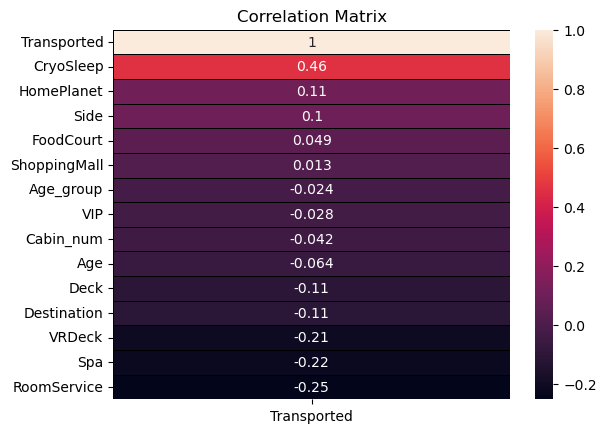

In [36]:
corr = (
    X_train_corr.corrwith(X_train_corr["Transported"])
    .sort_values(ascending=False)
    .to_frame()
)
corr.columns = ["Transported"]
sns.heatmap(corr, annot=True, linewidths=0.4, linecolor="black")
plt.title("Correlation Matrix")
plt.show()

- Positive Correlation: "CryoSleep", "HomePlanet", "Side", "FoodCourt", "ShoppingMall".

- Negative Correlation: "Age_group", "VIP", "Cabin_num", "Deck", "Destination", "VRDeck", "Spa", "RoomService".

### Feature Selection for Categorical Features :

In [37]:
categorical_features = [
    "CryoSleep",
    "HomePlanet",
    "Side",
    "Age_group",
    "VIP",
    "Deck",
    "Destination",
    "VRDeck",
]

#### Mutual Information Test 

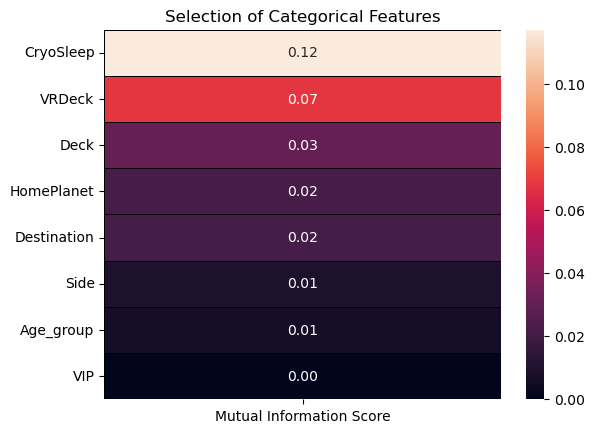

In [38]:
features = X_train.loc[:, categorical_features]
target = pd.DataFrame(y_train)

target_array = target.values.ravel()

# Feature selection
best_features = SelectKBest(score_func=mutual_info_classif, k="all")
fit = best_features.fit(features, target_array)

featureScores = pd.DataFrame(
    data=fit.scores_, index=list(features.columns), columns=["Mutual Information Score"]
)

sns.heatmap(
    featureScores.sort_values(ascending=False, by="Mutual Information Score"),
    annot=True,
    linewidths=0.4,
    linecolor="black",
    fmt=".2f",
)
plt.title("Selection of Categorical Features")
plt.show()

According to the above scores, there are no big dependencies on categorical features with the target variable **Transported**

#### Chi-Squared Test

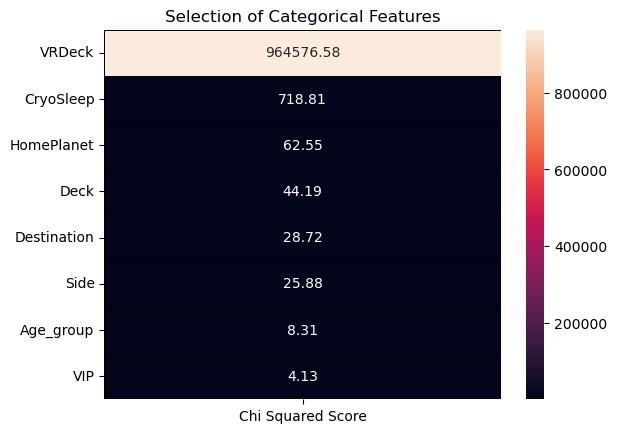

In [39]:
features = X_train.loc[:, categorical_features]
target = y_train

best_features = SelectKBest(score_func=chi2, k="all")
fit = best_features.fit(features, target)

featureScores = pd.DataFrame(
    data=fit.scores_, index=list(features.columns), columns=["Chi Squared Score"]
)
sns.heatmap(
    featureScores.sort_values(ascending=False, by="Chi Squared Score"),
    annot=True,
    linewidths=0.4,
    linecolor="black",
    fmt=".2f",
)
plt.title("Selection of Categorical Features")
plt.show()

We should reject the features that have low values. 

However, for now We're going to keep all of them and try to remove one by one later, checking how well the model will perform.

### Feature Selection for Numerical Features :

In [40]:
discrete_features = [
    "Age",
    "RoomService",
    "FoodCourt",
    "ShoppingMall",
    "Spa",
    "Cabin_num",
]

#### ANOVA Test

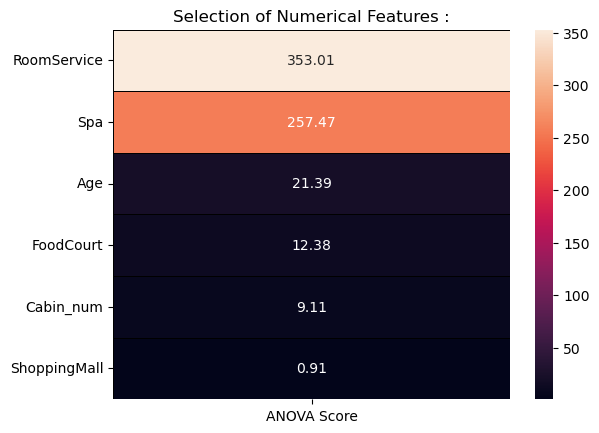

In [41]:
features = X_train.loc[:, discrete_features]
target = y_train

best_features = SelectKBest(score_func=f_classif, k="all")
fit = best_features.fit(features, target)

featureScores = pd.DataFrame(
    data=fit.scores_, index=list(features.columns), columns=["ANOVA Score"]
)
sns.heatmap(
    featureScores.sort_values(ascending=False, by="ANOVA Score"),
    annot=True,
    linewidths=0.4,
    linecolor="black",
    fmt=".2f",
)
plt.title("Selection of Numerical Features :")
plt.show()

The same would happen here. We should reject the features that have low values. 

We will ignore the Domain Information for now!

## Models

### Base Random Forest & XGBoost models

In [42]:
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

m.base_model_performance(
    classifier=rf_classifier, X_train=X_train, y_train=y_train, X_val=X_val, y_val=y_val
)

Cross Validation Mean Score:  78.99%
AUC ROC Score:  87.78%
Accuracy:  80.24%
Precision:  81.97%
Recall:  78.74%
F1:  80.32%


In [43]:
xgb_classifier = XGBClassifier(n_estimators=100, random_state=42)

m.base_model_performance(
    classifier=xgb_classifier,
    X_train=X_train,
    y_train=y_train,
    X_val=X_val,
    y_val=y_val,
)

Cross Validation Mean Score:  78.96%
AUC ROC Score:  88.83%
Accuracy:  79.21%
Precision:  80.28%
Recall:  78.74%
F1:  79.50%


**Droping Features**

Let's removing the lowest feature from categorical and numerical selection section and see if we have any improvement.
- VIP
- ShoppingMall

In [44]:
X_train2 = X_train.drop(columns=["VIP", "ShoppingMall"])
X_val2 = X_val.drop(columns=["VIP", "ShoppingMall"])

In [45]:
rf_classifier2 = RandomForestClassifier(n_estimators=100, random_state=42)

m.base_model_performance(
    classifier=rf_classifier2,
    X_train=X_train2,
    y_train=y_train,
    X_val=X_val2,
    y_val=y_val,
)

Cross Validation Mean Score:  78.67%
AUC ROC Score:  87.76%
Accuracy:  78.86%
Precision:  80.78%
Recall:  77.05%
F1:  78.87%


In [46]:
xgb_classifier2 = XGBClassifier(n_estimators=100, random_state=42)

m.base_model_performance(
    classifier=xgb_classifier2,
    X_train=X_train2,
    y_train=y_train,
    X_val=X_val2,
    y_val=y_val,
)

Cross Validation Mean Score:  78.63%
AUC ROC Score:  88.69%
Accuracy:  78.57%
Precision:  80.02%
Recall:  77.50%
F1:  78.74%


**Droping Features**

Let's removing the lowest feature from categorical and numerical selection section and see if we have any improvement.
- VIP & Age_group
- ShoppingMall & Cabin_num

In [47]:
X_train3 = X_train.drop(columns=["VIP", "ShoppingMall", "Age_group", "Cabin_num"])
X_val3 = X_val.drop(columns=["VIP", "ShoppingMall", "Age_group", "Cabin_num"])

In [48]:
rf_classifier3 = RandomForestClassifier(n_estimators=100, random_state=42)

m.base_model_performance(
    classifier=rf_classifier3,
    X_train=X_train3,
    y_train=y_train,
    X_val=X_val3,
    y_val=y_val,
)

Cross Validation Mean Score:  78.00%
AUC ROC Score:  85.28%
Accuracy:  77.76%
Precision:  79.21%
Recall:  76.72%
F1:  77.94%


In [49]:
xgb_classifier3 = XGBClassifier(n_estimators=100, random_state=42)

m.base_model_performance(
    classifier=xgb_classifier3,
    X_train=X_train3,
    y_train=y_train,
    X_val=X_val3,
    y_val=y_val,
)

Cross Validation Mean Score:  76.88%
AUC ROC Score:  86.98%
Accuracy:  78.57%
Precision:  77.95%
Recall:  81.10%
F1:  79.49%


#### Metrics Analysis

**Random Forest**

1. No Dropping

    - Cross Validation Mean Score: 78.99%
    - AUC ROC Score: 87.78%
    - Accuracy: 80.24%
    - Precision: 81.97%
    - Recall: 78.74%
    - F1: 80.32%

2. After Dropping VIP and ShoppingMall

    - Cross Validation Mean Score: 78.67% (-0.32)
    - AUC ROC Score: 87.76% (-0.02)
    - Accuracy: 78.86% (-1.38)
    - Precision: 80.78% (-1.19)
    - Recall: 77.05% (-1.69)
    - F1: 78.87% (-1.45)

3. After Dropping Age_group and Cabin_num

    - Cross Validation Mean Score: 78.00% (-0.99)
    - AUC ROC Score: 85.28% (-2.50)
    - Accuracy: 77.76% (-2.48)
    - Precision: 79.21% (-2.76)
    - Recall: 76.72% (-2.02)
    - F1: 77.94% (-2.38)

**XGBoost**

1. No Dropping

    - Cross Validation Mean Score: 78.96%
    - AUC ROC Score: 88.83%
    - Accuracy: 79.21%
    - Precision: 80.28%
    - Recall: 78.74%
    - F1: 79.50%

2. After Dropping VIP and ShoppingMall

    - Cross Validation Mean Score: 78.63% (-0.33)
    - AUC ROC Score: 88.69% (-0.14)
    - Accuracy: 78.57% (-0.64)
    - Precision: 80.02% (-0.26)
    - Recall: 77.50% (-1.24)
    - F1: 78.74% (-0.76)

3. After Dropping Age_group and Cabin_num

    - Cross Validation Mean Score: 76.88% (-1.95)
    - AUC ROC Score: 86.98% (-1.85)
    - Accuracy: 79.32% (+0.10)
    - Precision: 77.95% (-2.33)
    - Recall: 81.10% (+2.36)
    - F1: 79.49% (-0.01)

Analysis:
- XGBoost presented to have a good increase in the performance.
- Since "Accuracy" is our goal here. It got "+0.11" increase besides the other metrics.

With that in mind, let's see if we can tune that model and get a slight increase again.

**Explanation of Metrics**

**Cross Validation Score**:
- What it is: The average performance of the model across multiple splits of the data.
- Why it matters: Ensures consistent model performance on unseen data.

**ROC_AUC Score**:
- What it is: Measures the model's ability to distinguish between classes, with a higher score indicating better performance.
- Why it matters: Shows how well the model can differentiate between transported and non-transported cases.

**Accuracy**:

- What it is: The proportion of correctly predicted instances among the total instances.
- Why it matters: Indicates the overall correctness of the model.

**Precision**:
- What it is: The proportion of true stroke cases among all predicted transported cases.
- Why it matters: Important when false positives (predicting transported when there isn't one) are costly.

**Recall**:
- What it is: The proportion of actual transported cases correctly identified by the model.
- Why it matters: Crucial when missing a transported case (false negatives) is costly.

**F1-Score**:
- What it is: The harmonic mean of precision and recall, balancing both metrics.
- Why it matters: Provides a single measure that balances false positives and false negatives.

### Hyperparameter Tuning

For this section, Optuna will be our tool to find the best parameters for the XGBoost model 1.

In [50]:
def objective(trial, model_type):
    if model_type == "XGBoost":
        # Suggest hyperparameters for XGBClassifier
        n_estimators = trial.suggest_int("n_estimators", 50, 300)
        learning_rate = trial.suggest_float("learning_rate", 0.01, 0.3, log=True)
        max_depth = trial.suggest_int("max_depth", 3, 20)
        min_child_weight = trial.suggest_int("min_child_weight", 1, 10)
        gamma = trial.suggest_float("gamma", 0, 0.5)
        subsample = trial.suggest_float("subsample", 0.5, 1.0)

        # Create the XGBClassifier model with suggested hyperparameters
        model = XGBClassifier(
            n_estimators=n_estimators,
            learning_rate=learning_rate,
            max_depth=max_depth,
            min_child_weight=min_child_weight,
            gamma=gamma,
            subsample=subsample,
            random_state=42,
        )

    # Train the model
    model.fit(X_train, y_train)

    # Predict and calculate Accuracy score
    y_val_pred = model.predict(X_val)
    accuracy = accuracy_score(y_val, y_val_pred)

    return accuracy

In [51]:
model_type = "XGBoost"
study = optuna.create_study(direction="maximize")
study.optimize(lambda trial: objective(trial, model_type), n_trials=100)

# Print the best hyperparameters
print("Best hyperparameters: ", study.best_params)

[I 2024-08-05 18:30:30,536] A new study created in memory with name: no-name-f5788b4b-215e-46e9-a2ff-618279e458a2
[I 2024-08-05 18:30:30,681] Trial 0 finished with value: 0.804147465437788 and parameters: {'n_estimators': 212, 'learning_rate': 0.11077634463929407, 'max_depth': 3, 'min_child_weight': 1, 'gamma': 0.39353411273134487, 'subsample': 0.6954342157528496}. Best is trial 0 with value: 0.804147465437788.
[I 2024-08-05 18:30:31,069] Trial 1 finished with value: 0.7897465437788018 and parameters: {'n_estimators': 233, 'learning_rate': 0.28605103529551607, 'max_depth': 19, 'min_child_weight': 7, 'gamma': 0.11438023932422808, 'subsample': 0.7233661685198605}. Best is trial 0 with value: 0.804147465437788.
[I 2024-08-05 18:30:31,219] Trial 2 finished with value: 0.7897465437788018 and parameters: {'n_estimators': 55, 'learning_rate': 0.0349298170328416, 'max_depth': 13, 'min_child_weight': 7, 'gamma': 0.307955267038363, 'subsample': 0.8272314721190364}. Best is trial 0 with value: 0.

Best hyperparameters:  {'n_estimators': 151, 'learning_rate': 0.10476027633883152, 'max_depth': 5, 'min_child_weight': 1, 'gamma': 0.21224561533434366, 'subsample': 0.6497824766815576}


After tuning, let's validate our performance by using the **test dataset**

In [52]:
best_params = study.best_params
best_xgb_model = XGBClassifier(
    n_estimators=best_params["n_estimators"],
    learning_rate=best_params["learning_rate"],
    max_depth=best_params["max_depth"],
    min_child_weight=best_params["min_child_weight"],
    gamma=best_params["gamma"],
    subsample=best_params["subsample"],
    random_state=42,
)
best_xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.21224561533434366, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.10476027633883152,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=151, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [53]:
# Evaluate the final model
y_pred = best_xgb_model.predict(X_test)
roc_auc = roc_auc_score(y_test, y_pred)
print(f"Final ROC AUC Score: {roc_auc}")
# Classification Report
print(classification_report(y_test, best_xgb_model.predict(X_test)))

Final ROC AUC Score: 0.8082769967452923
              precision    recall  f1-score   support

           0       0.82      0.80      0.81       887
           1       0.80      0.81      0.81       849

    accuracy                           0.81      1736
   macro avg       0.81      0.81      0.81      1736
weighted avg       0.81      0.81      0.81      1736



**After Tuning Metrics**

ROC AUC Score:

- Before Tuning: 87.68%
- After Tuning: 80.16%

Accuracy Score:

- Before Tuning: 79.32%
- After Tuning: 81%

A decrease in ROC AUC score on unseen data is a common occurrence and highlights the importance of evaluating model performance using robust techniques that ensure generalization to new data.

However, our primary objective was to maximize "Accuracy" and ensure the model's generalization capabilities.

## Submission

### File Creation

In [54]:
predictions = best_xgb_model.predict(test_df)
n_predictions = (predictions > 0.5).astype(bool)
output = pd.DataFrame(
    {"PassengerId": submission_id, "Transported": n_predictions.squeeze()}
)

In [55]:
sample_submission_df = pd.read_csv("Data/sample_submission.csv")
sample_submission_df["Transported"] = n_predictions
sample_submission_df.to_csv("Data/submission.csv", index=False)